In [1]:
from torchvision.datasets import FashionMNIST as fm
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

# Device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from torchvision import datasets
from torch.utils.data import sampler
batch_size = 256
lr = 1e-4
n_epoch = 100
class ChunkSampler(sampler.Sampler): 
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples
train_loader = DataLoader(
    datasets.ImageFolder('/datasets/CelebA-stargan', transforms.Compose([
        transforms.CenterCrop((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # 用均值和方差归一化图片
    ])),
    batch_size=batch_size, shuffle=False,
    num_workers=32,pin_memory=True)

In [3]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.gen_1 = nn.Sequential(
            nn.ConvTranspose2d(10, 1024, 3, 1, 0, bias = False),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            
            nn.ConvTranspose2d(1024, 512, 5, 2, 2, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
            nn.ConvTranspose2d(512,256,5,2,2, bias = False),
            nn.BatchNorm2d(256),
            
        )
        self.gen_2 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, 2, 2, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, 5, 3, 3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, 5, 2, 2, 1, bias = False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, 5, 1, 1, bias = False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        self.gen_3 = nn.Sequential(
            
            nn.ConvTranspose2d(16, 3, 5, 1, 1, bias = False),
            nn.Tanh()
        )
        self.upsample_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10,
                      out_channels = 256,
                      kernel_size = 15,
                      stride = 3,
                      padding = 3,
                      output_padding = 2),)
        self.upsample_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256,
                      out_channels = 16,
                      kernel_size = 13,
                      stride = 13,
                      padding = 9,
                      output_padding = 1),)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = x
        sample = self.upsample_1(x)
        x = self.gen_1(x) #(128, 1, 28, 28)
        x = x.clone() + sample
        x = self.relu(x)
        out = x
        sample = self.upsample_2(x)
        x = self.gen_2(x)
        x = x.clone() + sample
        x = self.relu(x)
        x = self.gen_3(x)
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.dis_1 = nn.Sequential(
            nn.Conv2d(3, 16, 5, 1, 1, bias = False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(16, 32, 5, 1, 1,1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(32, 64, 5, 2, 1, bias = False),
            nn.BatchNorm2d(64),
            
        )
        self.dis_2 = nn.Sequential(
            nn.Conv2d(64, 128, 5, 1, 1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, 5, 2, 1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, 5, 3, 1, bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(512, 1024, 5, 3, 1, bias = False),
            nn.BatchNorm2d(1024),
            
        )
        self.dis_3 = nn.Sequential(
            nn.Conv2d(1024, 1, 3, 1, 0, bias = False),
        )#(batch_size , 1, 28, 28)
        self.downsample_1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,
                      out_channels = 64,
                      kernel_size = 8,
                      stride = 3,
                      padding = 30),)
        self.downsample_2 = nn.Sequential(
            nn.Conv2d(in_channels = 64,
                      out_channels = 1024,
                      kernel_size = 50,
                      stride = 5,
                      padding = 1),)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        out = x
        sample = self.downsample_1(x)
        x = self.dis_1(x)
        x = x.clone() + sample
        x = self.relu(x)
        out = x
        sample = self.downsample_2(x)
        x = self.dis_2(x)
        x = x.clone() + sample
        x = self.relu(x)
        x = self.dis_3(x)
        return x

In [5]:
G = Generator().to(device)
D = Discriminator().to(device)

In [6]:
optimizer_g = torch.optim.RMSprop(G.parameters(), lr = lr)
optimizer_d = torch.optim.RMSprop(D.parameters(), lr = lr)

In [7]:
losses_G = []
losses_D = []

In [8]:
for epoch in range(n_epoch):
    for i, (img, _) in enumerate(train_loader):
        img = img.to(device)
        
       ############ Training discriminator ######### 
        z = torch.randn(img.size(0),10,1,1).to(device)
        real_img = D(img)
        fake_img = G(z).detach()
        fake_img = D(fake_img)
        loss_D = -torch.mean(real_img)+ torch.mean(fake_img)
        
        for p in D.parameters():
            p.data.clamp_(-0.01,0.01)
        
        losses_D.append(loss_D.item())
        optimizer_d.zero_grad()
        loss_D.backward()
        optimizer_d.step()
        ti = 5
        
       ########### Training generator ###########
        z = torch.randn(img.size(0),10,1,1).to(device)
        fake_img_2 = G(z)
        output = D(fake_img_2)
        loss_G = -torch.mean(output)
        losses_G.append(loss_G.item())
        optimizer_g.zero_grad()
        loss_G.backward()
        optimizer_g.step()

    print('Epoch[{}/{}] D_loss:{:.4f}, G_loss:{:.4f} '.format(epoch+1, n_epoch,loss_D.item(), loss_G.item()))

Epoch[1/100] D_loss:-5.0120, G_loss:13.0448 
Epoch[2/100] D_loss:-22.2115, G_loss:-5.7800 
Epoch[3/100] D_loss:-3.7847, G_loss:-48.4054 
Epoch[4/100] D_loss:-28.2028, G_loss:2.5896 
Epoch[5/100] D_loss:-40.9869, G_loss:29.8692 
Epoch[6/100] D_loss:-55.1396, G_loss:2.6746 
Epoch[7/100] D_loss:-18.1356, G_loss:-47.0732 
Epoch[8/100] D_loss:15.8880, G_loss:-93.0584 
Epoch[9/100] D_loss:44.9974, G_loss:-73.6858 
Epoch[10/100] D_loss:37.9199, G_loss:-19.8665 
Epoch[11/100] D_loss:10.7278, G_loss:19.4818 
Epoch[12/100] D_loss:0.5331, G_loss:14.7826 
Epoch[13/100] D_loss:0.3101, G_loss:10.9433 
Epoch[14/100] D_loss:-0.2236, G_loss:4.5571 
Epoch[15/100] D_loss:-2.8942, G_loss:1.4754 
Epoch[16/100] D_loss:-4.5301, G_loss:8.6920 
Epoch[17/100] D_loss:-3.8685, G_loss:5.7149 
Epoch[18/100] D_loss:-7.1330, G_loss:7.9607 
Epoch[19/100] D_loss:-4.5848, G_loss:4.9745 
Epoch[20/100] D_loss:-5.4414, G_loss:6.8707 
Epoch[21/100] D_loss:-2.9638, G_loss:8.8616 
Epoch[22/100] D_loss:-3.0916, G_loss:11.0061 

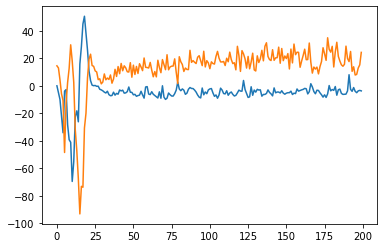

In [9]:
import matplotlib.pyplot as plt
plt.plot(losses_D, '-')
plt.plot(losses_G, '-')
plt.show()